# Galactic Comic Ray simulation for pyINCOM

In [1]:
%matplotlib inline 
%matplotlib ipympl
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sympy import symbols, solve
from scipy.interpolate import interp1d
from tqdm import tqdm

C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\1274240997.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Owner\anaconda3\envs\8820-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# data downloaded from https://www.sidc.be/SILSO/datafiles

year_df = pd.read_csv('SN_y_tot_V2.0.csv', sep='\;')

#Contents:
 #Column 1: Gregorian calendar year (mid-year date)
 #Column 2: Yearly mean total sunspot number.
 #Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.
 #Column 4: Number of observations used to compute the yearly mean total sunspot number.
 #Column 5: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

month_df = pd.read_csv('SN_m_tot_V2.0.csv', sep='\;')
month_s_df = pd.read_csv('SN_ms_tot_V2.0.csv', sep='\;')

#Contents:
  #Column 1-2: Gregorian calendar date, 1.Year, 2.Month
  #Column 3: Date in fraction of year for the middle of the corresponding month
  #Column 4: Monthly mean total sunspot number.
  #Column 5: Monthly mean standard deviation of the input sunspot numbers from individual stations.
  #Column 6: Number of observations used to compute the monthly mean total sunspot number.
  #Column 7: Definitive/provisional marker.

C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\1906181031.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  year_df = pd.read_csv('SN_y_tot_V2.0.csv', sep='\;')
C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\1906181031.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  month_df = pd.read_csv('SN_m_tot_V2.0.csv', sep='\;')
C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\1906181031.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning 

C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\3293271495.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(year_df['year'], year_df['mean'], yerr=year_df['std_dev'],


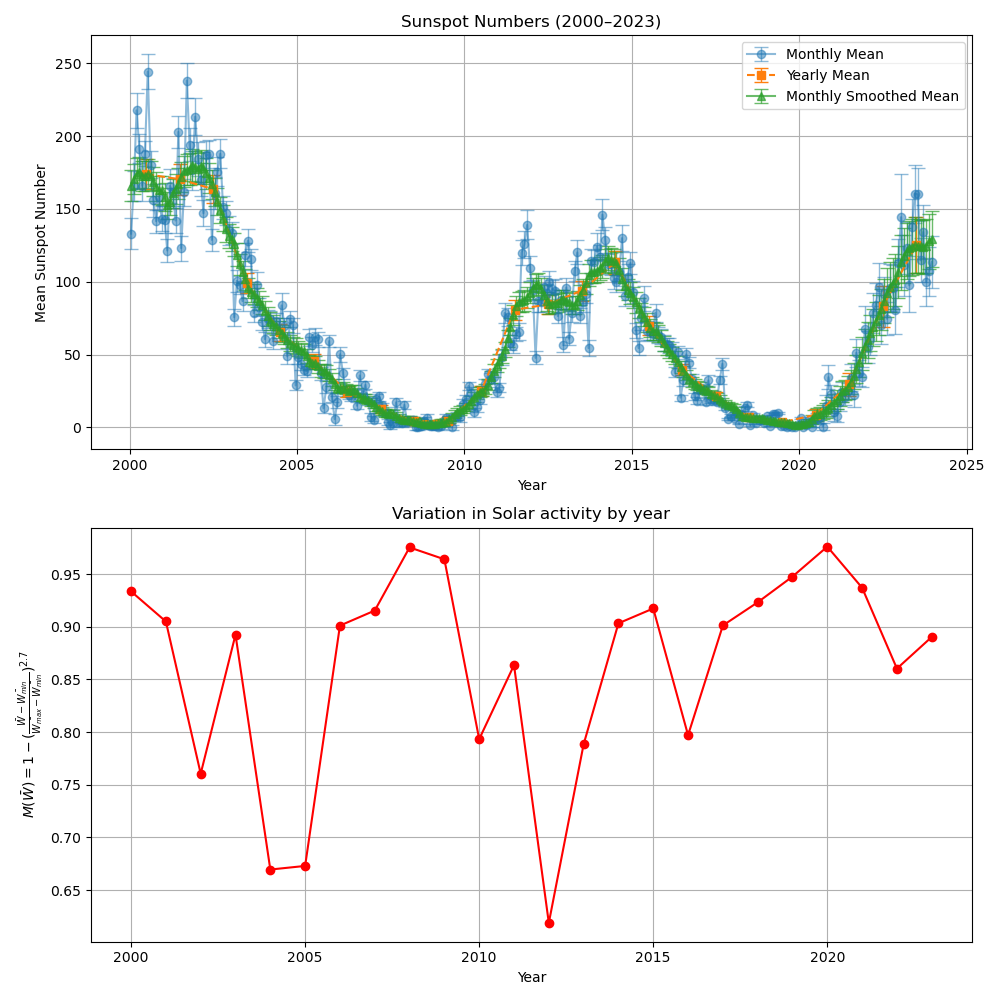

In [3]:
plt.close('all')

year_df.columns = ['year', 'mean', 'std_dev','num_obs','marker']
month_df.columns = ['year', 'month', 'date' ,'mean', 'std_dev','num_obs','marker']
month_s_df.columns = ['year', 'month', 'date' ,'mean', 'std_dev','num_obs','marker']

# Select data from 2000 to 2023 (covering two solar cycles)
year_df = year_df[(year_df['year'] >= 2000) & (year_df['year'] <= 2024)]
month_df = month_df[(month_df['year'] >= 2000) & (month_df['year'] < 2024)]
month_s_df = month_s_df[(month_s_df['year'] >= 2000) & (month_s_df['year'] < 2024)]

# Compute 12-month means for each year as well as min and max means by year
mean_min_by_year = month_df.groupby('year')['mean'].min().reset_index()
mean_max_by_year = month_df.groupby('year')['mean'].max().reset_index()
avg_means_by_year = month_df.groupby('year', as_index=False)['mean'].mean()

# Compute the function for M
M_values = 1 - ( (avg_means_by_year['mean'] - mean_min_by_year['mean']) / (mean_max_by_year['mean'] - mean_min_by_year['mean']) )**2.7


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot monthly mean sunspot number
ax1.errorbar(month_df['date'], month_df['mean'], yerr=month_df['std_dev'], 
            fmt='o-', capsize=5, elinewidth=1, markeredgewidth=1, label='Monthly Mean', alpha = 0.5)

# Plot yearly mean sunspot number
ax1.errorbar(year_df['year'], year_df['mean'], yerr=year_df['std_dev'], 
            fmt='s-', capsize=5, elinewidth=1, markeredgewidth=1, label='Yearly Mean', ls='--')

# Plot monthly smoothed mean sunspot number
ax1.errorbar(month_s_df['date'], month_s_df['mean'], yerr=month_s_df['std_dev'], 
            fmt='^-', capsize=5, elinewidth=1, markeredgewidth=1, label='Monthly Smoothed Mean',alpha = 0.7)

ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Sunspot Number')
ax1.set_title('Sunspot Numbers (2000–2023)')
ax1.grid(True)
ax1.legend()

ax2.plot(mean_min_by_year['year'], M_values, 'o-', color='red')
ax2.set_xlabel('Year')
ax2.set_ylabel(r'$M(\bar{W}) = 1 - (\frac{\bar{W} - \bar{W_{min}}}{\bar{W_{max}} - \bar{W_{min}}})^{2.7}$')
ax2.set_title('Variation in Solar activity by year')
ax2.grid(True)


plt.tight_layout()
plt.show()

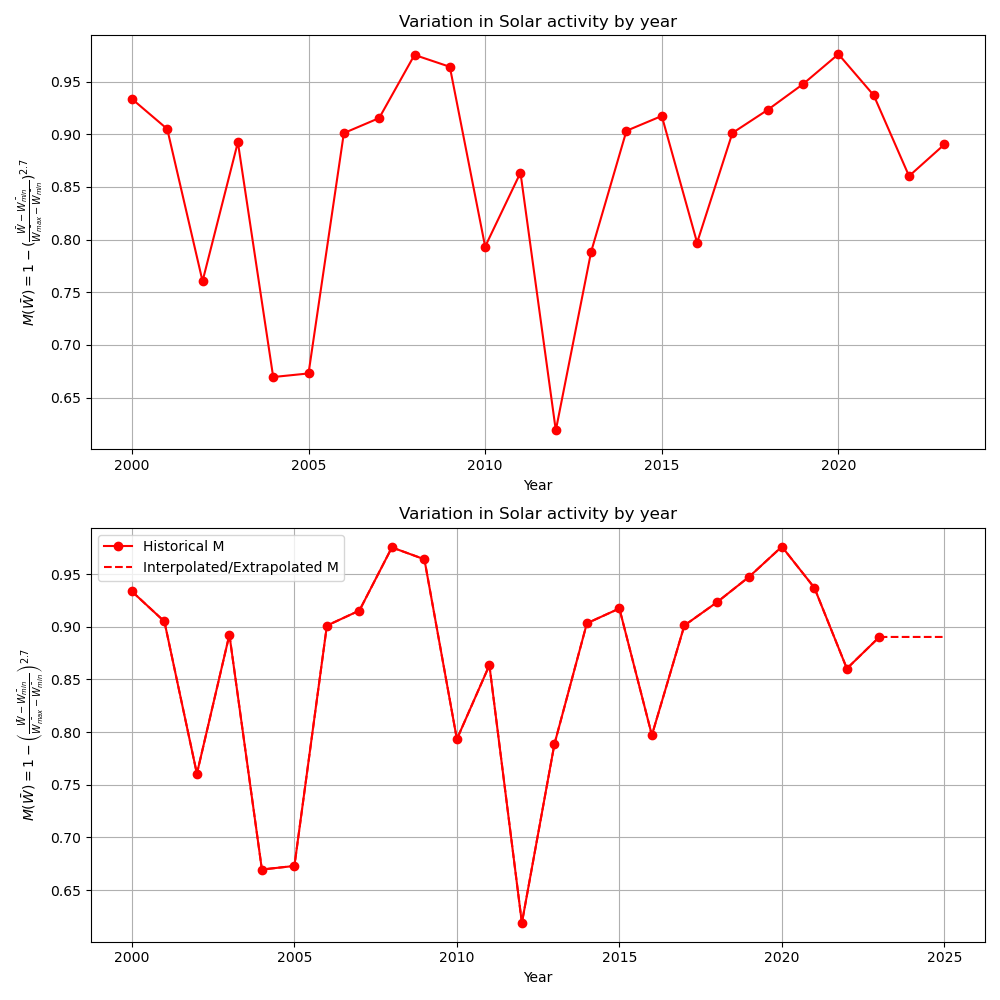

In [4]:
years = mean_min_by_year['year'].values
M_data = M_values.values  

M_interp = interp1d(years, M_data, kind='nearest', fill_value='extrapolate')

# Define the range of future years you wish to predict
future_years = np.arange(2025, 2026)  

# Evaluate the interpolating function at those future years
M_future = M_interp(future_years)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(mean_min_by_year['year'], M_values, 'o-', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'$M(\bar{W}) = 1 - (\frac{\bar{W} - \bar{W_{min}}}{\bar{W_{max}} - \bar{W_{min}}})^{2.7}$')
ax1.set_title('Variation in Solar activity by year')
ax1.grid(True)

ax2.plot(mean_min_by_year['year'], M_values, 'o-', color='red', label='Historical M')

all_years = np.arange(2000, 2026)  
M_smooth = M_interp(all_years)

ax2.plot(all_years, M_smooth, 'r--', label='Interpolated/Extrapolated M')

ax2.set_xlabel('Year')
ax2.set_ylabel(r'$M(\bar{W}) = 1 - \left(\frac{\bar{W} - \bar{W_{min}}}{\bar{W_{max}} - \bar{W_{min}}}\right)^{2.7}$')
ax2.set_title('Variation in Solar activity by year')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


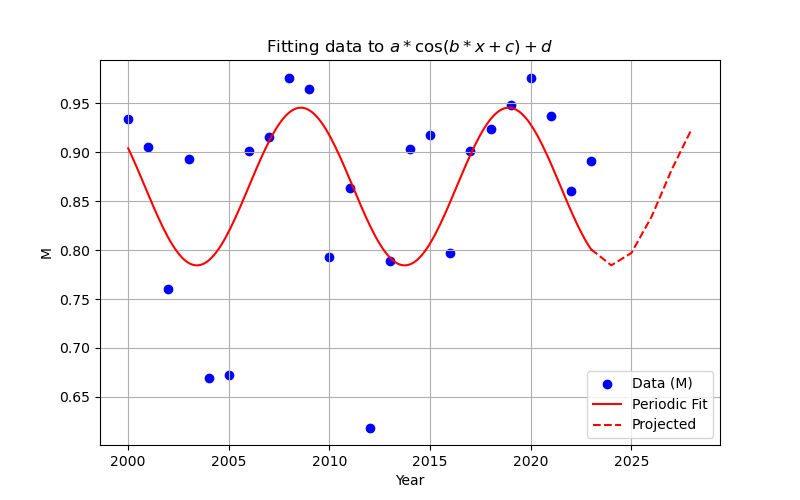

Fitted Parameters (popt):
a = -0.0805
b = 0.6085
c = -75.5487
d = 0.8649


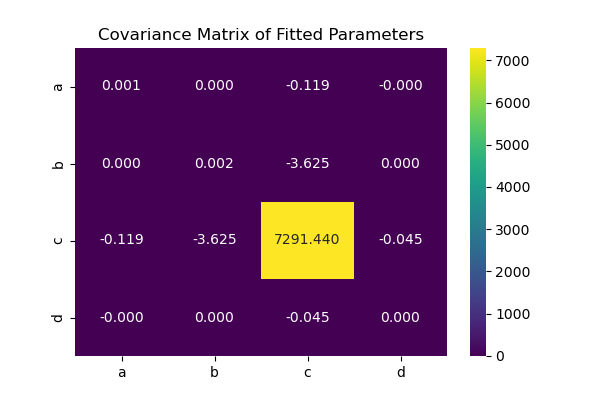

In [5]:
from scipy.optimize import curve_fit
import seaborn as sns

plt.close('all')

years = avg_means_by_year['year'].values       # e.g. [2000, 2001, 2002, ...]
M_data = M_values.values                       # e.g. [0.75, 0.72, 0.65, ...]

def periodic_model(x, a, b, c, d):
    """
    A periodic function with sine and cosine terms.
    x : float or array-like (independent variable, e.g. year)
    a, b, c, d : float (parameters to fit)
    """
    return a * np.cos(b * x + c) + d

initial_guesses = [.5, 2 * np.pi / 11 , 0.05, 0.7]

popt, pcov = curve_fit(periodic_model, years, M_data, p0=initial_guesses)


# Create a fine grid for plotting
x_fit = np.linspace(years.min(), years.max(), 200)
y_fit = periodic_model(x_fit, *popt)

# Optional: extrapolate beyond the data
x_future = np.arange(2023, 2028 + 1)  # 2023 to 2028
y_future = periodic_model(x_future, *popt)

plt.figure(figsize=(8, 5))
plt.scatter(years, M_data, color='blue', label='Data (M)')
plt.plot(x_fit, y_fit, 'r-', label='Periodic Fit')
plt.plot(x_future, y_future, 'r--', label='Projected')

# Annotate plot
plt.title('Fitting data to $a*\cos(b*x + c) + d$')
plt.xlabel('Year')
plt.ylabel('M')
plt.legend()
plt.grid(True)
plt.show()

a_opt, b_opt, c_opt, d_opt = popt

param_names = ["a", "b", "c", "d"]
print("Fitted Parameters (popt):")
for name, val in zip(param_names, popt):
    print(f"{name} = {val:.4f}")

# 6) Visualize the covariance matrix
plt.figure(figsize=(6, 4))
sns.heatmap(pcov, annot=True, fmt=".3f",
            xticklabels=param_names,
            yticklabels=param_names,
            cmap="viridis")
plt.title("Covariance Matrix of Fitted Parameters")
plt.show()

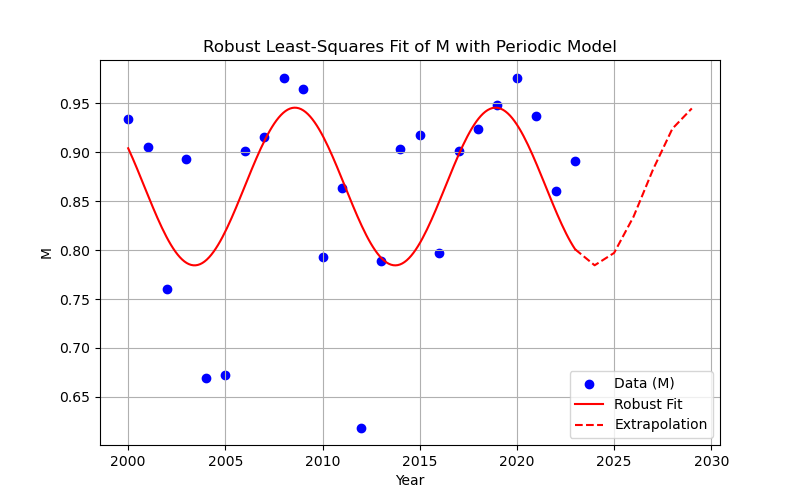

Robust Fit Parameters:
a = 0.08051
b = 0.60849
c = 40.71891
d = 0.86487


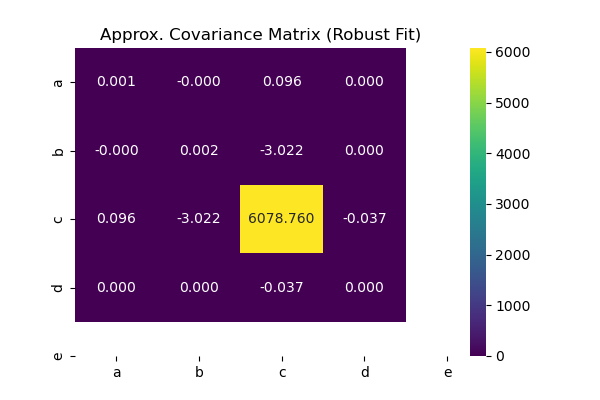

In [6]:
from scipy.optimize import least_squares

plt.close('all')

years = avg_means_by_year['year'].values.astype(float)
M_data = M_values.values.astype(float)

def periodic_model(x, a, b, c, d):
    """
    A periodic function with cosine + a cubic polynomial term.
    x: float or array (years)
    a, b, c, d, e: model parameters
    """
    return a * np.cos(b * x + c) + d

def residuals(params, x, y):
    a, b, c, d = params
    return y - periodic_model(x, a, b, c, d)


initial_guesses = [0.5, 2 * np.pi / 10, 0.05, 0.7]

res_robust = least_squares(
    fun=residuals,
    x0=initial_guesses,
    args=(years, M_data),
    loss='arctan',  # Options: 'linear', 'soft_l1', 'huber', 'cauchy', 'arctan'
    f_scale=1.0      # Adjust this scale if you want a different sensitivity to outliers
)

# The optimized parameters:
popt = res_robust.x
a_opt, b_opt, c_opt, d_opt = popt

J = res_robust.jac

residual_var = np.mean(res_robust.fun**2)
pcov = np.linalg.inv(J.T @ J) * residual_var  # approximate

x_fit = np.linspace(years.min(), years.max(), 200)
y_fit = periodic_model(x_fit, *popt)

# Extrapolate to future years
x_future = np.arange(2023, 2030)  # e.g., 2025, 2026
y_future = periodic_model(x_future, *popt)


plt.figure(figsize=(8, 5))
plt.scatter(years, M_data, color='blue', label='Data (M)')
plt.plot(x_fit, y_fit, 'r-', label='Robust Fit')
plt.plot(x_future, y_future, 'r--', label='Extrapolation')
plt.title('Robust Least-Squares Fit of M with Periodic Model')
plt.xlabel('Year')
plt.ylabel('M')
plt.legend()
plt.grid(True)
plt.show()

param_names = ["a", "b", "c", "d", "e"]
print("Robust Fit Parameters:")
for name, val in zip(param_names, popt):
    print(f"{name} = {val:.5f}")

plt.figure(figsize=(6, 4))
sns.heatmap(
    pcov, annot=True, fmt=".3f",
    xticklabels=param_names,
    yticklabels=param_names,
    cmap="viridis"
)
plt.title("Approx. Covariance Matrix (Robust Fit)")
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_54448\618360599.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  month_df = pd.read_csv('SN_m_tot_V2.0.csv', sep='\;')
100%|██████████| 5000/5000 [00:15<00:00, 322.65it/s]


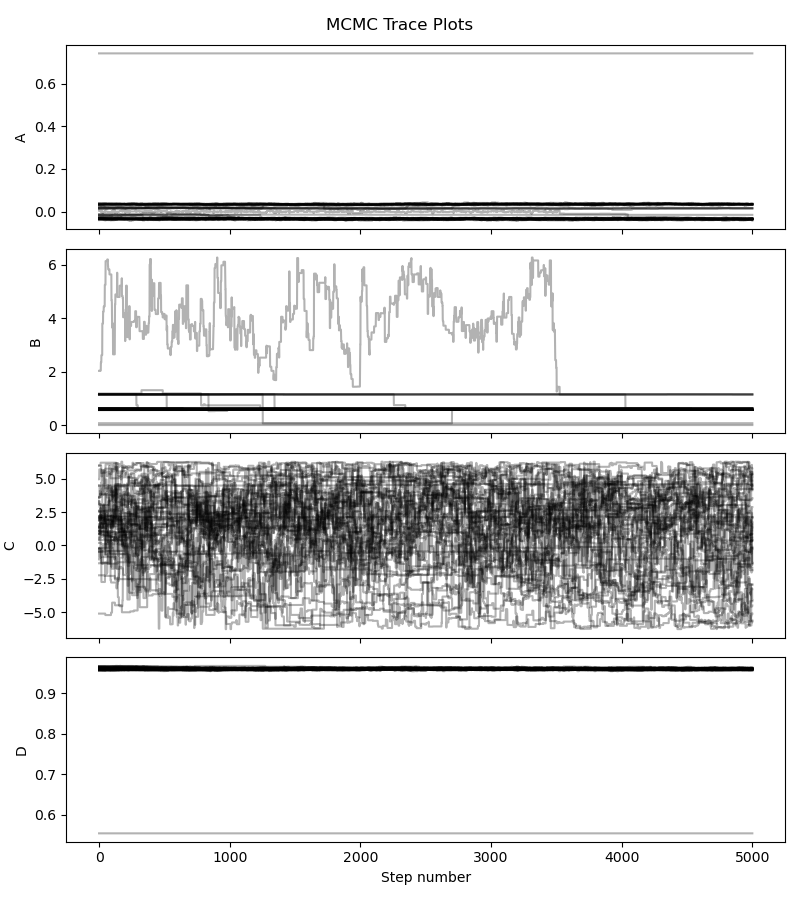

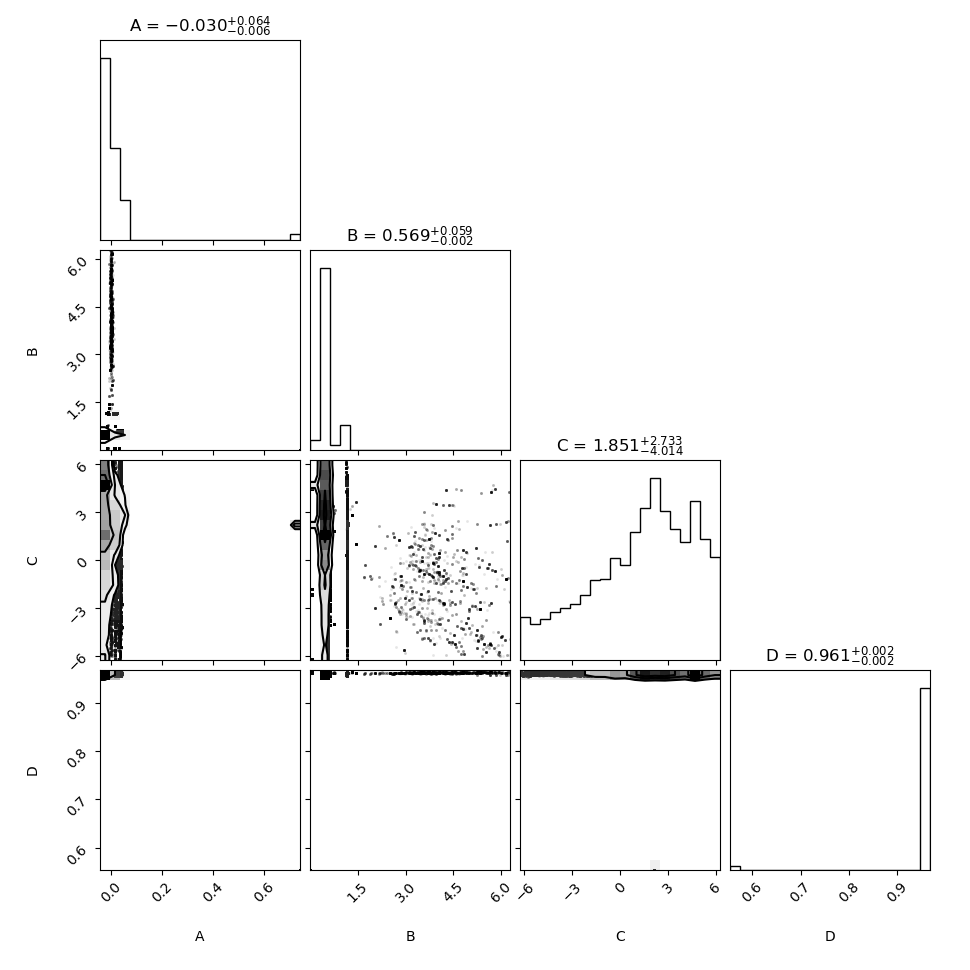

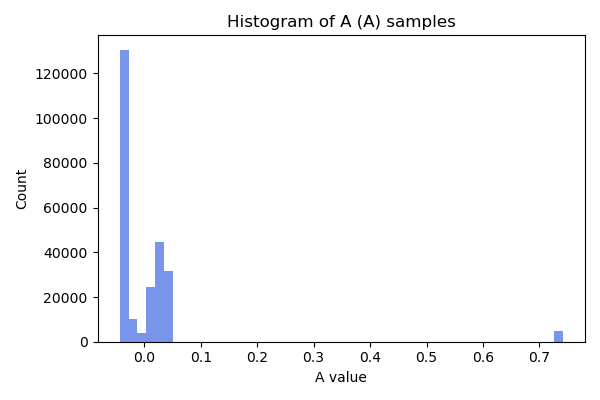


Median Posterior Parameters:
A = -0.030, B = 0.569, C = 1.851, D = 0.961


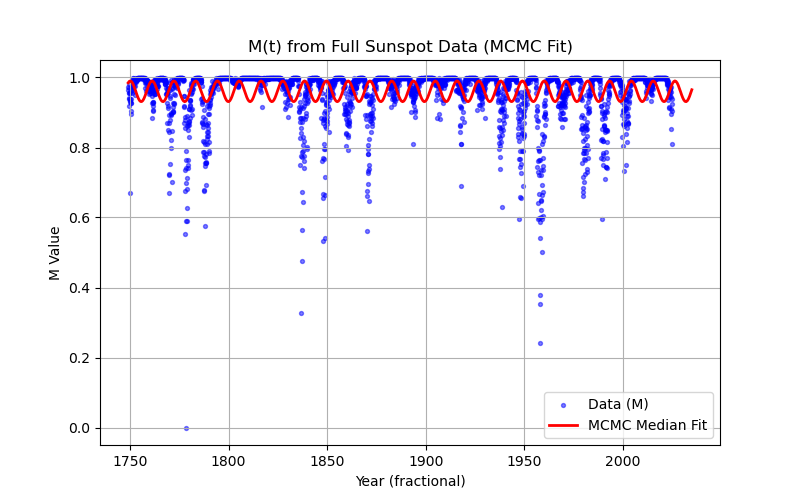

In [7]:
import emcee
import corner
import seaborn as sns

# Data Preparation
month_df = pd.read_csv('SN_m_tot_V2.0.csv', sep='\;')
month_df.columns = ['year', 'month', 'date' ,'mean', 'std_dev','num_obs','marker']

df_all = month_df.copy()  

df_all['date'] = pd.to_datetime(df_all['date'])

# Sort by date just to be sure
df_all.sort_values(by='date', inplace=True)

df_all['t_years'] = df_all['year'] + (df_all['month'] - 1)/12.0

W_min = df_all['mean'].min()
W_max = df_all['mean'].max()

df_all['M'] = 1 - ((df_all['mean'] - W_min) / (W_max - W_min))**2.7

# We'll treat 'M' as our dependent variable to be modeled.
t_data = df_all['t_years'].values  # independent variable
M_data = df_all['M'].values        # dependent variable

def model_M(t, A, B, C, D):
    """
    Example parametric function for M(t).
    You can change this to any smooth function you like.
    """
    return A * np.sin(B * t + C) + D


def log_prior(theta):
    """
    theta: [A, B, C, D]
    Return log(prior).
    For simplicity, assume broad Gaussian or uniform priors.
    Adjust as needed for domain knowledge.
    """
    A, B, C, D = theta
    
    # Example: Suppose A, B, C, D ~ broad uniform or normal
    # We'll do uniform checks for demonstration:
    if not (-10 < A < 10):
        return -np.inf
    if not (0 < B < 2*np.pi ):
        return -np.inf
    if not (-2*np.pi < C < 2*np.pi):
        return -np.inf
    if not (-2 < D < 2):
        return -np.inf
    
    # If within bounds, log_prior = 0 (flat prior)
    return 0.0

def log_likelihood(theta, t, M_obs, sigma=0.1):
    """
    theta: [A, B, C, D]
    t: array of time points
    M_obs: observed M(t)
    sigma: assumed measurement uncertainty
           (for simplicity, we assume constant or pass an array)
    Return log-likelihood under Gaussian errors.
    """
    # Model predictions
    A, B, C, D = theta
    M_mod = model_M(t, A, B, C, D)
    
    # Residuals
    resid = M_obs - M_mod
    ll = -0.5 * np.sum((resid / sigma)**2 + np.log(2*np.pi*sigma**2))
    return ll

def log_probability(theta, t, M_obs, sigma=0.1):
    """
    Full log posterior = log_prior + log_likelihood
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, M_obs, sigma=sigma)


initial = np.array([0.75, 2*np.pi /11, np.pi/2, 0.75])  # [A, B, C, D]
ndim = len(initial)    # number of parameters
nwalkers = 50          # number of MCMC walkers

# Initialize walker positions (small random scatter around 'initial')
pos = initial + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, 
    log_probability, 
    args=(t_data, M_data)  # pass data to log_probability
)

n_burn = 1000  # "burn-in" steps
n_steps = 5000 # total steps AFTER burn-in

# 1) Burn-in
state = sampler.run_mcmc(pos, n_burn, progress=True)
sampler.reset()

# 2) Main sampling
sampler.run_mcmc(state, n_steps, progress=True)

# The chain now holds the samples
samples = sampler.get_chain(discard=0, thin=1, flat=False)

# Plot the parameter traces (one way to see if sampler "settled")
fig, axes = plt.subplots(ndim, 1, figsize=(8, 9), sharex=True)
labels = ["A", "B", "C", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.suptitle("MCMC Trace Plots")
plt.tight_layout()
plt.show()

# Flatten the chain for corner plot
#   shape is (n_steps, nwalkers, ndim) => flatten out the first two dims
flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)

# Corner plot
fig_corner = corner.corner(
    flat_samples, 
    labels=labels, 
    show_titles=True, 
    title_fmt=".3f", 
    title_kwargs={"fontsize": 12}
)
plt.suptitle("Corner Plot of Posterior Distributions", y=1.02)
plt.show()

# Histogram of one parameter to see if it "settled down"
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(flat_samples[:, 0], bins=50, color='royalblue', alpha=0.7)
ax.set_title(f"Histogram of {labels[0]} (A) samples")
ax.set_xlabel("A value")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

best_fit = np.median(flat_samples, axis=0)
A_m, B_m, C_m, D_m = best_fit
print("\nMedian Posterior Parameters:")
print(f"A = {A_m:.3f}, B = {B_m:.3f}, C = {C_m:.3f}, D = {D_m:.3f}")

# Create a dense time grid that spans the full historical data + some future
t_min, t_max = t_data.min(), t_data.max()
t_dense = np.linspace(t_min, t_max + 10, 500)  # e.g., 10 years beyond
M_dense = model_M(t_dense, A_m, B_m, C_m, D_m)

# Plot final interpolation
plt.figure(figsize=(8,5))
plt.scatter(t_data, M_data, color='blue', s=8, alpha=0.5, label="Data (M)")
plt.plot(t_dense, M_dense, 'r-', lw=2, label="MCMC Median Fit")
plt.title("M(t) from Full Sunspot Data (MCMC Fit)")
plt.xlabel("Year (fractional)")
plt.ylabel("M Value")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
class CosmicRaySimulator:
    def __init__(self, max_Z=28, grid_size=4088, step_size=0.1, helio_potential=0.125):
        """
        Initialize the cosmic ray simulator.

        Parameters
        ----------
        max_Z : int
            The maximum Z number for the cosmic ray distribution (default: 28).
        grid_size : int
            The number of pixels on each side of the output image (default: 4088).
        step_size : float
            Step size in micrometers for particle tracking (default: 0.1 µm).
        """
        self.max_Z = max_Z
        self.grid_size = grid_size
        self.step_size = step_size

        # Constants
        self.c = 2.99792458e8  # speed of light in m/s
        self.e = 1.602176634e-19  # elementary charge in C

        # Particle definitions
        self.Z_list = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
        self.m_list = [
            5.109989461e5,0.9382720813e9, 
            2*(0.9382720813e9) + 2*(0.9395654133e9),
            3*(0.9382720813e9) + 4*(0.9395654133e9), 
            4*(0.9382720813e9) + 5*(0.9395654133e9),
            5*(0.9382720813e9) + 6*(0.9395654133e9),
            6*(0.9382720813e9) + 6*(0.9395654133e9), 
            7*(0.9382720813e9) + 7*(0.9395654133e9),
            8*(0.9382720813e9) + 8*(0.9395654133e9), 
            9*(0.9382720813e9) + 10*(0.9395654133e9),
            10*(0.9382720813e9) + 10*(0.9395654133e9), 
            11*(0.9382720813e9) + 12*(0.9395654133e9),
            12*(0.9382720813e9) + 12*(0.9395654133e9),
            13*(0.9382720813e9) + 14*(0.9395654133e9),
            14*(0.9382720813e9) + 14*(0.9395654133e9), 
            15*(0.9382720813e9) + 16*(0.9395654133e9),
            16*(0.9382720813e9) + 16*(0.9395654133e9),
            17*(0.9382720813e9) + 18*(0.9395654133e9),
            18*(0.9382720813e9) + 22*(0.9395654133e9),
            19*(0.9382720813e9) + 20*(0.9395654133e9),
            20*(0.9382720813e9) + 20*(0.9395654133e9),
            21*(0.9382720813e9) + 24*(0.9395654133e9),
            22*(0.9382720813e9) + 26*(0.9395654133e9),
            23*(0.9382720813e9) + 28*(0.9395654133e9),
            24*(0.9382720813e9) + 28*(0.9395654133e9),
            25*(0.9382720813e9) + 30*(0.9395654133e9),
            26*(0.9382720813e9) + 30*(0.9395654133e9),
            27*(0.9382720813e9) + 32*(0.9395654133e9),
            28*(0.9382720813e9) + 30*(0.9395654133e9)
        ]
        self.A_list = [
            1.0, 1.0, (4.0 / 4), (6.9 / 7), (9.0 / 9), (10.8 / 11), (12.0 / 12), (14.0 / 14), (16.0 / 16), (19.0 / 19),
            (20.2 / 20), (23.0 / 23), (24.3 / 24), (27.0 / 27), (28.1 / 28), (31.0 / 31), (32.1 / 32), (35.4 / 35),
            (39.9 / 40), (39.1 / 39), (40.1 / 40), (44.9 / 45), (47.9 / 48), (50.9 / 51), (52.0 / 52), (54.9 / 55),
            (55.8 / 56), (58.9 / 59), (58.7 / 58)
        ]
        self.C_list = [
            170, 1.85e4, 3.69e3, 19.5, 17.7, 49.2, 103.0, 36.7, 87.4, 3.19, 16.4, 4.43, 19.3, 4.17, 13.4, 1.15, 3.06, 1.30,
            2.33, 1.87, 2.17, 0.74, 2.63, 1.23, 2.12, 1.14, 9.32, 0.10, 0.49
        ]
        self.alpha_list = [
            1, 2.85, 3.12, 3.41, 4.30, 3.93, 3.18, 3.77, 3.11, 4.05, 3.11, 3.14, 3.65, 3.46, 3.00,
            4.04, 3.30, 4.40, 4.33, 4.49, 2.93, 3.78, 3.79, 3.50, 3.28, 3.29, 3.01, 4.25, 3.52
        ]
        self.gamma_values_list = [
            2.74, 2.77, 2.82, 3.05, 2.96, 2.76, 2.89, 2.70, 2.82, 2.76, 2.84, 2.70, 2.77, 2.66, 2.89,
            2.71, 3.00, 2.93, 3.05, 2.77, 2.97, 2.99, 2.94, 2.89, 2.74, 2.63, 2.63, 2.63
        ]

        # Energy and phi arrays 
        self.start_energy = [
            1e8, 1e7, 1e7, 7e8, 1e8, 9e8, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6,
            1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6
        ]
        self.stop_energy = [
            1e10, 1e11, 1e12, 3e10, 1e12, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13,
            1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13,
            1e13, 1e13, 1e13, 1e13, 1e13, 1e13, 1e13
        ]
        self.start_phi = [
            1e-8, 1e-7, 1e-8, 6e-10, 1e-10, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 
            1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 
            1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11, 1e-11
        ]
        self.stop_phi = [
            2e-7, 2e-5, 0.6e-5, 2e-9, 3e-9, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,
            1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,
            1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8
        ]

        # Determine max_slice based on max_Z
        if self.max_Z in self.Z_list:
            max_index = self.Z_list.index(self.max_Z)
        else:
            max_index = max(i for i,z in enumerate(self.Z_list) if z <= self.max_Z)
        max_slice = max_index + 1

        # Slice all arrays to ensure consistent lengths
        self.Z = self.Z_list[:max_slice]
        self.m = self.m_list[:max_slice]
        self.A = self.A_list[:max_slice]
        self.C = self.C_list[:max_slice]
        self.alpha = self.alpha_list[:max_slice]
        self.gamma_values = self.gamma_values_list[:max_slice]
        self.start_energy = self.start_energy[:max_slice]
        self.stop_energy = self.stop_energy[:max_slice]
        self.start_phi = self.start_phi[:max_slice]
        self.stop_phi = self.stop_phi[:max_slice]

        # ISO-15390 parameters
        self.R_e = 1  # rigidity param for electron in GV
        self.R_0 = helio_potential  # Effective modulation potential in GV, default set to 0.125
        self.M_polar = 1 # Sun's magnetic field polarity factor

        # Other simulation parameters
        self.dt = 140  # seconds
        self.dA = 1e-10  # m^2
        self.dOmega = 2*np.pi  # sr

        # Pixel and absorber parameters
        self.pixel_pitch = 10  # micrometers
        self.absorber_thickness = 5  # micrometers

    def rigidity(self, energy, A, Z, m):
        R = (A/abs(Z)) * (np.sqrt(energy*(energy+2*m)))*1e-9
        return max(R, 1e-20)

    def relative_velocity(self, energy, m):
        beta = (1/(energy+m)) * (np.sqrt(energy*(energy+2*m)))
        return max(beta, 1e-20)

    def gamma_func(self, R, i):
        if i == 0:
            return 3.0 - 1.4*np.exp(-R/self.R_e)
        else:
            return self.gamma_values[i-1]

    def Delta(self, Z, beta, R):
        D = 5.5 + 1.3*(Z/abs(Z))*self.M_polar*((beta*R)/self.R_0)*np.exp(-(beta*R)/self.R_0)
        return D

    def log_rigidity_spectrum(self, alpha, beta, g, C, R, D):
        R = max(R,1e-20)
        ln_phi = np.log(C) + alpha*np.log(beta) - g*np.log(R) + D*np.log(R/(R+self.R_0))
        return ln_phi

    def delta_rigidity(self, E, delta_E, A, Z, m):
        numerator = (A / abs(Z)) * (E + m) * delta_E
        denominator = np.sqrt(E*(E+2*m))
        delta_R = (numerator / denominator)*1e-9
        return delta_R

    def generate_angles(self, init_en):
        # Uses proton mass at index [1]
        vel = np.sqrt((2 * init_en) / self.m[1])
        P = np.random.uniform(0, 1)
        theta = np.arcsin(np.sqrt(P))
        phi = np.random.uniform(0, 2 * np.pi)
        return theta, phi, vel

    def apply_streak(self, heatmap, x, y, theta, phi, init_en, vel, SID, streaks):
        L = self.absorber_thickness * np.tan(theta)
        num_steps = int(L * self.pixel_pitch / self.step_size)
        current_energy = init_en

        for i in range(num_steps):
            if current_energy <= 0:
                break
            dx_um = i * self.step_size * np.cos(phi)
            dy_um = i * self.step_size * np.sin(phi)
            new_x = x * self.pixel_pitch + dx_um
            new_y = y * self.pixel_pitch + dy_um
            grid_x = int(new_x / self.pixel_pitch)
            grid_y = int(new_y / self.pixel_pitch)
            if 0 <= grid_x < self.grid_size and 0 <= grid_y < self.grid_size:
                heatmap[grid_y, grid_x] += 1
                if i == 0:  # Only annotate the first point of the streak
                    streaks.append((new_x, new_y, SID, num_steps, theta, phi))
            dE = 1
            current_energy -= dE
            if current_energy <= 0:
                break
            vel = np.sqrt((2 * current_energy) / self.m[1])

    def generate_image(self):
        # Prepare final heatmap
        num_pixels = self.grid_size
        heatmap = np.zeros((num_pixels, num_pixels), dtype=int)

        num_part_table = []
        for y in range(len(self.Z)):
            kin_energy_bins = np.logspace(np.log10(self.start_energy[y]), np.log10(self.stop_energy[y]), 101)
            kin_energies = (kin_energy_bins[:-1] + kin_energy_bins[1:]) / 2
            delta_energies = np.diff(kin_energy_bins)

            product_values = []
            for iE in range(len(kin_energies)):
                E = kin_energies[iE]
                delta_E = delta_energies[iE]
                R = self.rigidity(E, self.A[y], self.Z[y], self.m[y])
                beta = self.relative_velocity(E, self.m[y])
                g = self.gamma_func(R,y)
                D = self.Delta(self.Z[y], beta, R)

                ln_phi = self.log_rigidity_spectrum(self.alpha[y], beta, g, self.C[y], R, D)
                phi = np.exp(ln_phi)
                if not np.isfinite(phi) or phi <=0:
                    phi = 0.0

                delta_R = self.delta_rigidity(E, delta_E, self.A[y], self.Z[y], self.m[y])
                product = phi * delta_R * self.dOmega * self.dt * self.dA
                product_values.append(product)

            product_values = np.array(product_values)
            product_values[product_values <= 0] = np.nan

            year_df_bins = pd.DataFrame({
                'Start Energy (eV)': kin_energy_bins[:-1],
                'End Energy (eV)': kin_energy_bins[1:],
                'Bin Center Energy (eV)': kin_energies,
                'Bin Width (eV)': delta_energies,
                'Mean # of particles': product_values
            })
            num_part_table.append(year_df_bins)

        # Simulate placement of particles on the grid
        for i in tqdm(range(len(self.Z)), desc="Processing species"):
            for j in range(len(num_part_table[i])):
                lambda_value = num_part_table[i]['Mean # of particles'].iat[j] * (num_pixels**2)
                if lambda_value <= 0 or not np.isfinite(lambda_value):
                    continue
                poisson_samples = np.random.poisson(lambda_value, 1)

                if poisson_samples.sum() == 0:
                    continue

                E_min = num_part_table[i]['Start Energy (eV)'].iat[j]
                E_max = num_part_table[i]['End Energy (eV)'].iat[j]

                points = []
                streaks = []
                for SID in range(1, poisson_samples.sum()+1):
                    x = np.random.randint(0, num_pixels)
                    y = np.random.randint(0, num_pixels)
                    init_en = np.random.uniform(E_min, E_max)
                    theta, phi, vel = self.generate_angles(init_en)
                    points.append((x, y, theta, phi, init_en, vel))
                    self.apply_streak(heatmap, x, y, theta, phi, init_en, vel, SID, streaks)

        return heatmap

In [9]:
# Create a simulator object and generate an image
pixel_pitch = 10  # Size of each pixel in micrometers (analogous to pixel pitch)
absorber_thickness = 5  # Depth of each pixel in micrometers (analogous to pixel thickness)

image = CosmicRaySimulator(max_Z=28, grid_size=4088).generate_image()  # 'image' is a 4088x4088 numpy array with the simulated distribution.

Processing species: 100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


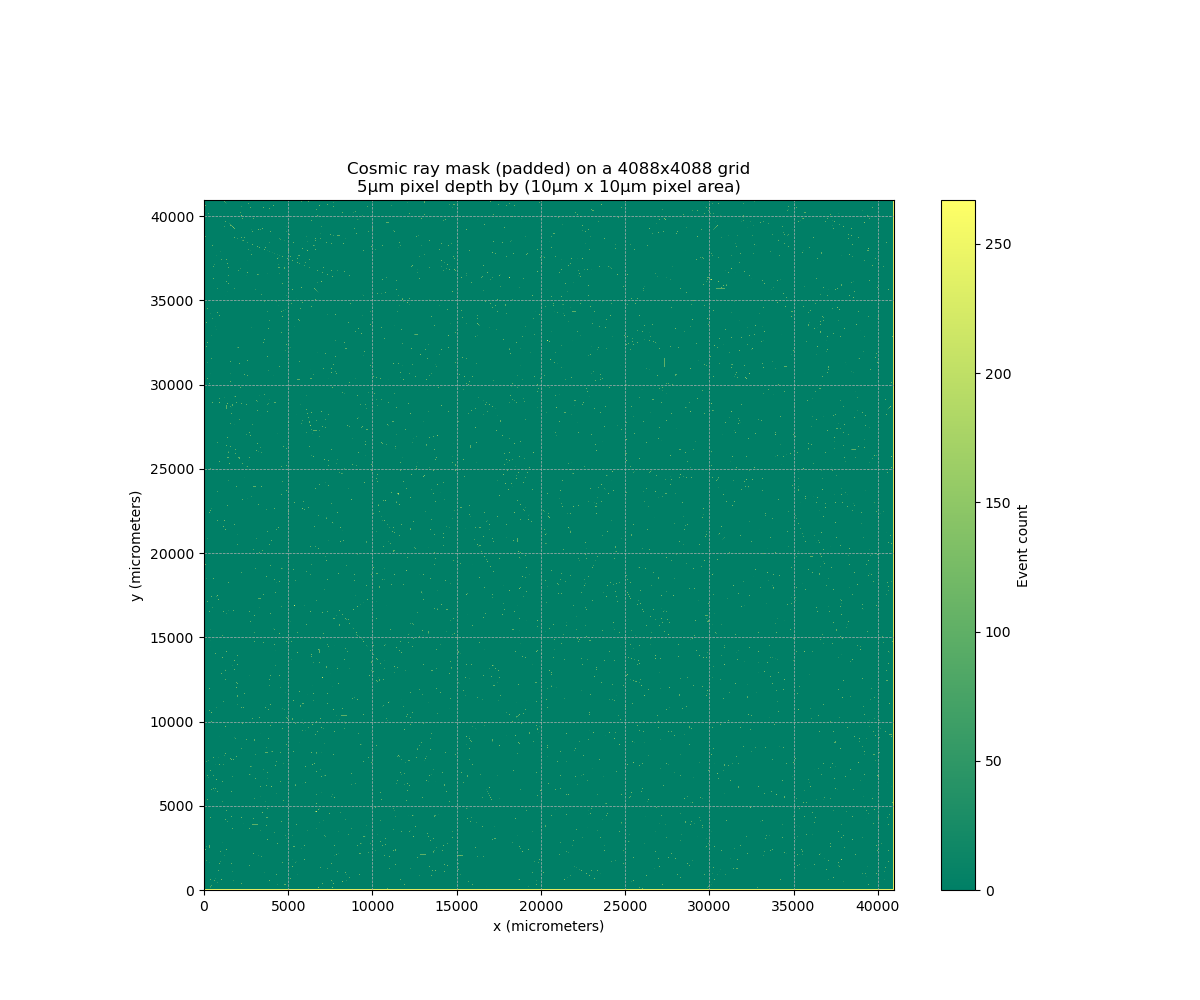

In [10]:
padded_image = np.pad(image, pad_width=4, mode='constant', constant_values=250)

# Plot the padded_image
plt.figure(figsize=(12, 10))
plt.imshow(padded_image, cmap="summer", interpolation='nearest', origin='lower', extent=[0, len(padded_image) * pixel_pitch, 0, len(padded_image) * pixel_pitch])
plt.colorbar(label='Event count')
plt.title(f'Cosmic ray mask (padded) on a {len(image)}x{len(image)} grid\n{absorber_thickness}µm pixel depth by ({10}µm x {10}µm pixel area)')
plt.subplots_adjust(top=0.8)
plt.xlabel('x (micrometers)')
plt.ylabel('y (micrometers)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()